In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

In [3]:
from utility_functions import *

In [60]:
pd.set_option('display.max_columns', None)

# Load data

In [88]:
# Read data
features_df = pd.read_csv("data_features_df_dropna.csv", parse_dates=['Date'])
features_df['Date'] = pd.to_datetime(features_df['Date'])

In [78]:
feature_cols = [
    'cum_return_prev5d','cum_return_prev21d','cum_return_prev63d','cum_return_prev1d',
    'cum_return_09:30_10:00','cum_return_10:00_11:30','cum_return_11:30_13:30',
    'cum_return_13:30_15:15','relative_volume_prev09:30_11:30', # 'relative_volume_15:30',
    'relative_volume_prev11:30_13:30','relative_volume_prev13:30_16:00',
    'relative_volume_09:30_10:00','relative_volume_10:00_11:30',
    'relative_volume_11:30_13:30','relative_volume_13:30_15:30',
    'volume_resid_return_corr','volume_raw_return_corr','volatility_1d',
    'volatility_21d_raw','volatility_21d_resid','volatility_63d_raw',
    'volatility_63d_resid','hlc_ratio','hlc_21mean','skewness_1d',
    'skewness_21d_resid','skewness_63d_resid'
]
target_col = 'y'

In [89]:
features_df = features_df[['Date', 'Id', 'y', 'weight'] + feature_cols] # Delete 'relative_volume_15:30'. Fully colinearity

# Corr

weighted correlation

In [84]:
cols = ['y'] + feature_cols
weighted_corr_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)

# Calculate weighted corr for every feature
for i in range(len(cols)):
    for j in range(len(cols)):
        col_i = cols[i]
        col_j = cols[j]
        weighted_corr_matrix.loc[col_i, col_j] = weighted_corr(
            features_df[col_i].to_numpy(),
            features_df[col_j].to_numpy(),
            features_df['weight'].to_numpy()
        )

## Corr with y

In [85]:
weighted_corr_matrix['y'].sort_values(key=lambda x: x.abs(), ascending=False)

y                                  1.000000
volatility_1d                     -0.122444
cum_return_09:30_10:00             0.109204
volatility_21d_raw                -0.076873
cum_return_prev1d                  0.073957
cum_return_prev5d                  0.035021
volatility_63d_raw                -0.033469
volatility_21d_resid              -0.026169
cum_return_prev21d                 0.017414
cum_return_13:30_15:15            -0.015255
volatility_63d_resid              -0.014022
skewness_1d                        0.012392
skewness_21d_resid                 0.011508
skewness_63d_resid                 0.010475
cum_return_prev63d                 0.008480
hlc_ratio                         -0.007782
volume_raw_return_corr             0.007644
volume_resid_return_corr           0.007233
relative_volume_09:30_10:00       -0.005688
cum_return_10:00_11:30            -0.005279
relative_volume_prev13:30_16:00    0.003809
relative_volume_10:00_11:30       -0.002271
relative_volume_13:30_15:30     

## plot correlation matrix

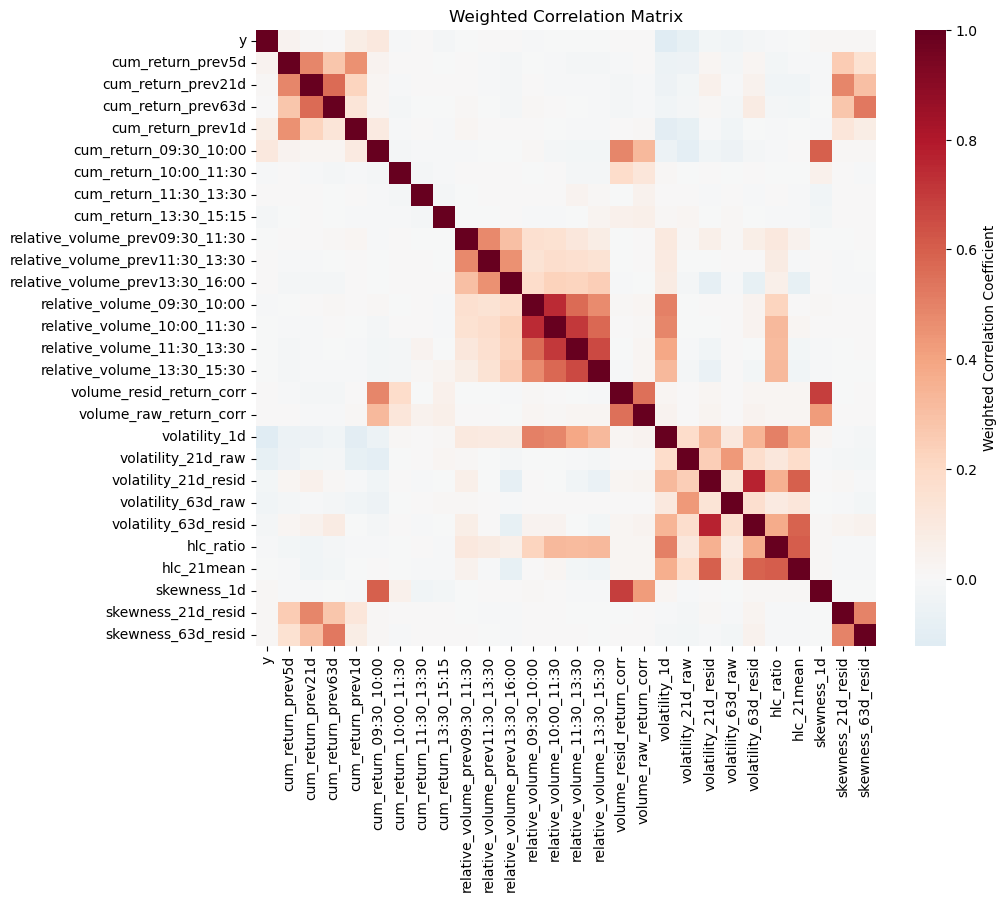

In [86]:
plt.figure(figsize=(10, 8))
sns.heatmap(weighted_corr_matrix, annot=False, cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Weighted Correlation Coefficient'})
plt.title("Weighted Correlation Matrix")
plt.show()

Volume features have high correlation between each other

Volatility features have high correlation between each other

# Train-Test split

In [90]:
train_start = '2010-04-07'
train_end   = '2013-12-31'
val_start   = '2014-01-01'
val_end     = '2015-12-31'

X_train = features_df[features_df['Date'] < val_start][feature_cols]
y_train = features_df[features_df['Date'] < val_start]['y']
w_train = features_df[features_df['Date'] < val_start]['weight']

X_val = features_df[features_df['Date'] >= val_start][feature_cols]
y_val = features_df[features_df['Date'] >= val_start]['y']
w_val = features_df[features_df['Date'] >= val_start]['weight']

## normalization

In [91]:
pipeline = Pipeline([
    ('scaler', StandardScaler())  # Only normalization
])

X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)

## winsorization

In [42]:
# TO DO

## evaluate function

In [92]:
def evaluate(model):
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # evaluate training set
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    train_r2_weighted = weighted_r2(y_train, y_train_pred, w_train)
    train_corr = pd.Series(y_train_pred, index=y_train.index).corr(y_train)
    train_corr_weighted = weighted_corr(y_train, y_train_pred, w_train)

    # evaluate validation set
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    val_r2_weighted = weighted_r2(y_val, y_val_pred, w_val)
    val_corr = pd.Series(y_val_pred, index=y_val.index).corr(y_val)
    val_corr_weighted = weighted_corr(y_val, y_val_pred, w_val)

    # results output
    if isinstance(model, LinearRegression):
        print("Linear Regression (alpha=0):")
    elif isinstance(model, Lasso):
        print(f"Lasso Regression (alpha={model.alpha}):")
    elif isinstance(model, Ridge):
        print(f"Ridge Regression (alpha={model.alpha}):")
    
    print(f"Train MSE: {train_mse:.8f}, Train R^2 Weighted: {train_r2_weighted:.8f}, Train R^2: {train_r2:.8f}, Train Corr Weighted: {train_corr_weighted:.8f}, Train Corr: {train_corr:.8f}")
    print(f"Val MSE:   {val_mse:.8f}, Val R^2 Weighted:   {val_r2_weighted:.8f}, Val R^2:   {val_r2:.8f}, Val Corr Weighted:   {val_corr_weighted:.8f}, Val Corr:   {val_corr:.8f}")
    print("Coefficients:")
    display(pd.DataFrame([model.coef_], columns=feature_cols))
    print("-" * 50)

    # results dictionary
    result = {
        'alpha': 0 if isinstance(model, LinearRegression) else model.alpha,
        'train_mse': train_mse,
        'train_r2_weighted': train_r2_weighted,
        'train_r2': train_r2,
        'train_corr_weighted': train_corr_weighted,
        'train_corr': train_corr,
        'val_mse': val_mse,
        'val_r2_weighted': val_r2_weighted,
        'val_r2': val_r2,
        'val_corr_weighted': val_corr_weighted,
        'val_corr': val_corr,
        **{f"{feature}": coef for feature, coef in zip(feature_cols, model.coef_)}
    }

    return result

# OLS

In [93]:
### 1. Linear Regression (alpha=0)
lr = LinearRegression()
lr.fit(X_train, y_train, sample_weight=w_train)

ols_result = evaluate(lr)

Linear Regression (alpha=0):
Train MSE: 0.00021139, Train R^2 Weighted: 0.05488014, Train R^2: 0.06235960, Train Corr Weighted: 0.23426511, Train Corr: 0.24999062
Val MSE:   0.00016667, Val R^2 Weighted:   -0.02382988, Val R^2:   -0.02466623, Val Corr Weighted:   0.01470177, Val Corr:   0.01174344
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000049,0.000011,-0.000169,0.000563,0.002256,0.00008,-0.000024,-0.000136,-0.000066,-0.000011,0.000037,0.000786,0.000601,0.000255,0.000003,-0.000337,-0.000016,-0.00314,-0.000594,-0.000118,-0.00002,0.00039,0.000522,0.000672,-0.000812,0.00003,0.000069


--------------------------------------------------


In [94]:
# output statistics
ols_model = sm.WLS(y_train, sm.add_constant(pd.DataFrame(X_train, columns=feature_cols)), weights=w_train)
ols_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.055
Model:                            WLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     972.8
Date:                Tue, 11 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:24:08   Log-Likelihood:             1.2626e+06
No. Observations:              452341   AIC:                        -2.525e+06
Df Residuals:                  452313   BIC:                        -2.525e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -8.742e-05   2.14e-05     -4.094      0.000      -0.000   -4.56e-05
cum_return_prev5d                4.887e-05   2.71e-05      1.804      0.071   -4.24e-06       0.000
cum_return_prev21d                1.09e-05   3.16e-05      0.345      0.730    -5.1e-05    7.28e-05
cum_return_prev63d                 -0.0002   2.97e-05     -5.683      0.000      -0.000      -0.000
cum_return_prev1d                   0.0006   2.49e-05     22.627      0.000       0.001       0.001
cum_return_09:30_10:00              0.0023   2.77e-05     81.546      0.000       0.002       0.002
cum_return_10:00_11:30            7.96e-05   2.26e-05      3.529      0.000    3.54e-05       0.000
cum_return_11:30_13:30          -2.425e-05   2.19e-05     -1.105      0.269   -6.73e-05    1.88e-05
cum_return_13:30_15:15             -0.0001    2.2e-05     -6.186      0.000      -0.000   -9.28e-05
relative_volume_prev09:30_11:30 -6.585e-05   2.49e-05     -2.648      0.008      -0.000   -1.71e-05
relative_volume_prev11:30_13:30 -1.089e-05   2.69e-05     -0.405      0.685   -6.35e-05    4.18e-05
relative_volume_prev13:30_16:00  3.723e-05   2.55e-05      1.462      0.144   -1.27e-05    8.71e-05
relative_volume_09:30_10:00         0.0008    3.5e-05     22.432      0.000       0.001       0.001
relative_volume_10:00_11:30         0.0006   4.07e-05     14.757      0.000       0.001       0.001
relative_volume_11:30_13:30         0.0003   3.57e-05      7.144      0.000       0.000       0.000
relative_volume_13:30_15:30       2.66e-06   3.16e-05      0.084      0.933   -5.93e-05    6.46e-05
volume_resid_return_corr           -0.0003   3.17e-05    -10.606      0.000      -0.000      -0.000
volume_raw_return_corr          -1.552e-05   2.47e-05     -0.628      0.530    -6.4e-05    3.29e-05
volatility_1d                      -0.0031      3e-05   -104.524      0.000      -0.003      -0.003
volatility_21d_raw                 -0.0006    2.5e-05    -23.784      0.000      -0.001      -0.001
volatility_21d_resid               -0.0001   3.45e-05     -3.423      0.001      -0.000   -5.05e-05
volatility_63d_raw              -2.004e-05   2.02e-05     -0.991      0.322   -5.97e-05    1.96e-05
volatility_63d_resid                0.0004   3.37e-05     11.583      0.000       0.000       0.000
hlc_ratio                           0.0005   3.12e-05     16.699      0.000       0.000       0.001
hlc_21mean                          0.0007   3.22e-05     20.894      0.000       0.001       0.001
skewness_1d                        -0.0008   3.16e-05    -25.700      0.000      -0.001      -0.001
skewness_21d_resid               3.005e-05   2.79e-05      1.076      0.282   -2.47e-05    8.48e-05
skewness_63d_resid               6.943e-05   2.89e-05      2.400      0.016    1.27

# Lasso

## training - grid search

In [99]:
# Store all results
results = [ols_result]

In [100]:
for alpha in [1e-6, 3e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 8e-5, 1e-4, 2e-4, 5e-4, 5e-3]:
    lasso = Lasso(alpha=alpha) #, max_iter=10000)  # 设置 max_iter 确保收敛
    lasso.fit(X_train, y_train, sample_weight=w_train)
    
    result = evaluate(lasso)
    results.append(result)

Lasso Regression (alpha=1e-06):
Train MSE: 0.00021139, Train R^2 Weighted: 0.05487996, Train R^2: 0.06235455, Train Corr Weighted: 0.23426483, Train Corr: 0.24999104
Val MSE:   0.00016666, Val R^2 Weighted:   -0.02377044, Val R^2:   -0.02460563, Val Corr Weighted:   0.01471494, Val Corr:   0.01175672
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000048,0.000008,-0.000165,0.000562,0.002254,0.000078,-0.000023,-0.000135,-0.000065,-0.000009,0.000035,0.000784,0.0006,0.000254,0.000002,-0.000336,-0.000015,-0.003138,-0.000594,-0.000114,-0.000019,0.000385,0.000521,0.00067,-0.00081,0.000031,0.000067


--------------------------------------------------
Lasso Regression (alpha=3e-06):
Train MSE: 0.00021139, Train R^2 Weighted: 0.05487847, Train R^2: 0.06234320, Train Corr Weighted: 0.23426257, Train Corr: 0.24999004
Val MSE:   0.00016664, Val R^2 Weighted:   -0.02365168, Val R^2:   -0.02448448, Val Corr Weighted:   0.01474177, Val Corr:   0.01178389
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000048,0.000003,-0.000157,0.000562,0.00225,0.000075,-0.000021,-0.000133,-0.000063,-0.000006,0.000032,0.000781,0.0006,0.000253,0.000002,-0.000334,-0.000013,-0.003132,-0.000594,-0.000105,-0.000018,0.000376,0.000519,0.000667,-0.000807,0.000032,0.000063


--------------------------------------------------
Lasso Regression (alpha=5e-06):
Train MSE: 0.00021140, Train R^2 Weighted: 0.05487558, Train R^2: 0.06233047, Train Corr Weighted: 0.23425824, Train Corr: 0.24998702
Val MSE:   0.00016662, Val R^2 Weighted:   -0.02353440, Val R^2:   -0.02436502, Val Corr Weighted:   0.01476807, Val Corr:   0.01180964
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000046,0.0,-0.00015,0.000562,0.002245,0.000072,-0.000019,-0.000131,-0.00006,-0.000003,0.000028,0.000778,0.000599,0.000251,0.000001,-0.000333,-0.000012,-0.003126,-0.000595,-0.000096,-0.000016,0.000368,0.000518,0.000664,-0.000804,0.000032,0.000058


--------------------------------------------------
Lasso Regression (alpha=6e-06):
Train MSE: 0.00021140, Train R^2 Weighted: 0.05487369, Train R^2: 0.06232374, Train Corr Weighted: 0.23425544, Train Corr: 0.24998502
Val MSE:   0.00016662, Val R^2 Weighted:   -0.02347678, Val R^2:   -0.02430654, Val Corr Weighted:   0.01478056, Val Corr:   0.01182106
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000045,0.0,-0.000147,0.000562,0.002243,0.000071,-0.000018,-0.00013,-0.000059,-0.000001,0.000027,0.000776,0.000599,0.000251,9.919754e-07,-0.000332,-0.000011,-0.003123,-0.000595,-0.000092,-0.000016,0.000363,0.000517,0.000662,-0.000802,0.000031,0.000057


--------------------------------------------------
Lasso Regression (alpha=7e-06):
Train MSE: 0.00021140, Train R^2 Weighted: 0.05487147, Train R^2: 0.06231667, Train Corr Weighted: 0.23425216, Train Corr: 0.24998249
Val MSE:   0.00016661, Val R^2 Weighted:   -0.02341960, Val R^2:   -0.02424850, Val Corr Weighted:   0.01479269, Val Corr:   0.01183222
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000044,0.0,-0.000144,0.000562,0.002241,0.00007,-0.000016,-0.00013,-0.000058,-0.0,0.000025,0.000774,0.000598,0.00025,6.928830e-07,-0.000331,-0.000011,-0.00312,-0.000595,-0.000088,-0.000015,0.000359,0.000516,0.00066,-0.000801,0.000031,0.000055


--------------------------------------------------
Lasso Regression (alpha=8e-06):
Train MSE: 0.00021140, Train R^2 Weighted: 0.05486900, Train R^2: 0.06230923, Train Corr Weighted: 0.23424856, Train Corr: 0.24997942
Val MSE:   0.00016660, Val R^2 Weighted:   -0.02336319, Val R^2:   -0.02419132, Val Corr Weighted:   0.01480350, Val Corr:   0.01184243
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000043,0.0,-0.000141,0.000562,0.002238,0.000068,-0.000015,-0.000129,-0.000057,-0.0,0.000024,0.000773,0.000598,0.00025,3.932556e-07,-0.00033,-0.00001,-0.003117,-0.000595,-0.000084,-0.000014,0.000355,0.000515,0.000659,-0.000799,0.00003,0.000053


--------------------------------------------------
Lasso Regression (alpha=9e-06):
Train MSE: 0.00021140, Train R^2 Weighted: 0.05486620, Train R^2: 0.06230146, Train Corr Weighted: 0.23424446, Train Corr: 0.24997586
Val MSE:   0.00016659, Val R^2 Weighted:   -0.02330709, Val R^2:   -0.02413446, Val Corr Weighted:   0.01481425, Val Corr:   0.01185261
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000042,0.0,-0.000138,0.000562,0.002236,0.000067,-0.000014,-0.000128,-0.000055,-0.0,0.000022,0.000771,0.000598,0.000249,9.325915e-08,-0.000329,-0.000009,-0.003114,-0.000595,-0.00008,-0.000013,0.00035,0.000514,0.000657,-0.000798,0.00003,0.000051


--------------------------------------------------
Lasso Regression (alpha=1e-05):
Train MSE: 0.00021141, Train R^2 Weighted: 0.05486308, Train R^2: 0.06229342, Train Corr Weighted: 0.23423988, Train Corr: 0.24997187
Val MSE:   0.00016658, Val R^2 Weighted:   -0.02325140, Val R^2:   -0.02407803, Val Corr Weighted:   0.01482525, Val Corr:   0.01186296
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.00004,0.0,-0.000136,0.000562,0.002234,0.000065,-0.000013,-0.000127,-0.000053,-0.0,0.000021,0.000769,0.000597,0.000248,0.0,-0.000328,-0.000009,-0.003111,-0.000595,-0.000076,-0.000013,0.000346,0.000514,0.000655,-0.000796,0.00003,0.000049


--------------------------------------------------
Lasso Regression (alpha=2e-05):
Train MSE: 0.00021143, Train R^2 Weighted: 0.05481375, Train R^2: 0.06219481, Train Corr Weighted: 0.23416622, Train Corr: 0.24990453
Val MSE:   0.00016649, Val R^2 Weighted:   -0.02270748, Val R^2:   -0.02352620, Val Corr Weighted:   0.01493459, Val Corr:   0.01196694
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000029,0.0,-0.000108,0.000561,0.002211,0.000051,-0.000002,-0.000118,-0.000037,-0.0,0.000008,0.000752,0.000594,0.000241,0.0,-0.00032,-0.000002,-0.003081,-0.000597,-0.000034,-0.000005,0.000304,0.000505,0.000639,-0.000781,0.000025,0.000031


--------------------------------------------------
Lasso Regression (alpha=3e-05):
Train MSE: 0.00021146, Train R^2 Weighted: 0.05473933, Train R^2: 0.06207146, Train Corr Weighted: 0.23405701, Train Corr: 0.24980167
Val MSE:   0.00016640, Val R^2 Weighted:   -0.02219838, Val R^2:   -0.02300848, Val Corr Weighted:   0.01500640, Val Corr:   0.01203391
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000018,0.0,-0.00008,0.000561,0.002189,0.000036,-0.0,-0.000109,-0.000021,-0.0,0.0,0.000735,0.000589,0.000234,0.0,-0.000309,-0.0,-0.00305,-0.000596,-0.0,-0.0,0.000266,0.000496,0.000624,-0.000766,0.000021,0.000012


--------------------------------------------------
Lasso Regression (alpha=4e-05):
Train MSE: 0.00021148, Train R^2 Weighted: 0.05465971, Train R^2: 0.06194589, Train Corr Weighted: 0.23395450, Train Corr: 0.24970982
Val MSE:   0.00016632, Val R^2 Weighted:   -0.02170752, Val R^2:   -0.02251118, Val Corr Weighted:   0.01505791, Val Corr:   0.01207365
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000008,0.0,-0.000057,0.00056,0.002166,0.000022,-0.0,-0.000101,-0.000007,-0.0,0.0,0.000717,0.000582,0.000225,0.0,-0.000297,-0.0,-0.003017,-0.00059,-0.0,-0.0,0.00025,0.000487,0.000615,-0.000751,0.000014,0.0


--------------------------------------------------
Lasso Regression (alpha=5e-05):
Train MSE: 0.00021152, Train R^2 Weighted: 0.05456649, Train R^2: 0.06180685, Train Corr Weighted: 0.23383946, Train Corr: 0.24960499
Val MSE:   0.00016625, Val R^2 Weighted:   -0.02123403, Val R^2:   -0.02203391, Val Corr Weighted:   0.01512030, Val Corr:   0.01211842
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,0.0,-0.000039,0.00056,0.002143,0.000007,-0.0,-0.000092,-0.0,-0.0,0.0,0.000701,0.000575,0.000216,0.0,-0.000285,-0.0,-0.002984,-0.000584,-0.0,-0.0,0.000236,0.000478,0.000607,-0.000736,0.000002,0.0


--------------------------------------------------
Lasso Regression (alpha=8e-05):
Train MSE: 0.00021162, Train R^2 Weighted: 0.05424445, Train R^2: 0.06133090, Train Corr Weighted: 0.23350182, Train Corr: 0.24925923
Val MSE:   0.00016602, Val R^2 Weighted:   -0.01990063, Val R^2:   -0.02066946, Val Corr Weighted:   0.01523377, Val Corr:   0.01224699
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,-0.0,-0.0,0.000545,0.002078,0.0,-0.0,-0.000065,-0.0,-0.0,0.0,0.000653,0.000555,0.000192,0.0,-0.00026,-0.0,-0.002887,-0.000564,0.0,-0.0,0.000193,0.000453,0.00058,-0.000687,0.0,0.0


--------------------------------------------------
Lasso Regression (alpha=0.0001):
Train MSE: 0.00021171, Train R^2 Weighted: 0.05398074, Train R^2: 0.06096395, Train Corr Weighted: 0.23324748, Train Corr: 0.24899796
Val MSE:   0.00016588, Val R^2 Weighted:   -0.01906400, Val R^2:   -0.01981450, Val Corr Weighted:   0.01531689, Val Corr:   0.01232863
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,-0.0,-0.0,0.000538,0.002036,0.0,-0.0,-0.000047,-0.0,0.0,0.0,0.000621,0.000542,0.000175,0.0,-0.000246,-0.0,-0.002823,-0.000552,0.0,-0.0,0.000169,0.000436,0.000559,-0.000653,0.0,0.0


--------------------------------------------------
Lasso Regression (alpha=0.0002):
Train MSE: 0.00021231, Train R^2 Weighted: 0.05184554, Train R^2: 0.05828907, Train Corr Weighted: 0.23084165, Train Corr: 0.24653181
Val MSE:   0.00016530, Val R^2 Weighted:   -0.01557392, Val R^2:   -0.01620504, Val Corr Weighted:   0.01568835, Val Corr:   0.01281034
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,0.0,-0.0,0.000503,0.001825,0.0,-0.0,-0.0,0.0,0.0,0.0,0.000465,0.000475,0.000093,0.0,-0.000169,-0.0,-0.002502,-0.000487,0.0,-0.0,0.000048,0.000352,0.000453,-0.00049,0.0,0.0


--------------------------------------------------
Lasso Regression (alpha=0.0005):
Train MSE: 0.00021568, Train R^2 Weighted: 0.03871345, Train R^2: 0.04331685, Train Corr Weighted: 0.20586363, Train Corr: 0.22068401
Val MSE:   0.00016452, Val R^2 Weighted:   -0.01120171, Val R^2:   -0.01140986, Val Corr Weighted:   0.01511199, Val Corr:   0.01317130
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,0.0,0.0,0.000387,0.001223,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.00019,0.0,0.0,-0.0,-0.0,-0.001597,-0.000301,0.0,-0.0,0.0,0.00008,0.0,-0.0,0.0,0.0


--------------------------------------------------
Lasso Regression (alpha=0.005):
Train MSE: 0.00022545, Train R^2 Weighted: 0.00000000, Train R^2: -0.00000013, Train Corr Weighted: 0.00000000, Train Corr: 0.00000000
Val MSE:   0.00016266, Val R^2 Weighted:   -0.00000350, Val R^2:   -0.00000400, Val Corr Weighted:   nan, Val Corr:   0.00000000
Coefficients:


c:\Users\52431\0_ml\ml-project\utility_functions.py:19: RuntimeWarning: invalid value encountered in scalar divide
  return cov_xy / np.sqrt(var_x * var_y)


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0


--------------------------------------------------


In [101]:
results_df = pd.DataFrame(results)
results_df = results_df.drop_duplicates()
results_df = results_df.sort_values(by='alpha').reset_index(drop=True)
results_df

,alpha,train_mse,train_r2_weighted,train_r2,train_corr_weighted,train_corr,val_mse,val_r2_weighted,val_r2,val_corr_weighted,val_corr,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,hlc_ratio,hlc_21mean,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000000,0.000211,0.054880,6.235960e-02,2.342651e-01,2.499906e-01,0.000167,-0.023830,-0.024666,0.014702,1.174344e-02,0.000049,0.000011,-0.000169,0.000563,0.002256,0.000080,-0.000024,-0.000136,-0.000066,-0.000011,0.000037,0.000786,0.000601,0.000255,2.659895e-06,-0.000337,-0.000016,-0.003140,-0.000594,-0.000118,-0.000020,0.000390,0.000522,0.000672,-0.000812,0.000030,0.000069
1,0.000001,0.000211,0.054880,6.235455e-02,2.342648e-01,2.499910e-01,0.000167,-0.023770,-0.024606,0.014715,1.175672e-02,0.000048,0.000008,-0.000165,0.000562,0.002254,0.000078,-0.000023,-0.000135,-0.000065,-0.000009,0.000035,0.000784,0.000600,0.000254,2.362493e-06,-0.000336,-0.000015,-0.003138,-0.000594,-0.000114,-0.000019,0.000385,0.000521,0.000670,-0.000810,0.000031,0.000067
2,0.000003,0.000211,0.054878,6.234320e-02,2.342626e-01,2.499900e-01,0.000167,-0.023652,-0.024484,0.014742,1.178389e-02,0.000048,0.000003,-0.000157,0.000562,0.002250,0.000075,-0.000021,-0.000133,-0.000063,-0.000006,0.000032,0.000781,0.000600,0.000253,1.826127e-06,-0.000334,-0.000013,-0.003132,-0.000594,-0.000105,-0.000018,0.000376,0.000519,0.000667,-0.000807,0.000032,0.000063
3,0.000005,0.000211,0.054876,6.233047e-02,2.342582e-01,2.499870e-01,0.000167,-0.023534,-0.024365,0.014768,1.180964e-02,0.000046,0.000000,-0.000150,0.000562,0.002245,0.000072,-0.000019,-0.000131,-0.000060,-0.000003,0.000028,0.000778,0.000599,0.000251,1.291960e-06,-0.000333,-0.000012,-0.003126,-0.000595,-0.000096,-0.000016,0.000368,0.000518,0.000664,-0.000804,0.000032,0.000058
4,0.000006,0.000211,0.054874,6.232374e-02,2.342554e-01,2.499850e-01,0.000167,-0.023477,-0.024307,0.014781,1.182106e-02,0.000045,0.000000,-0.000147,0.000562,0.002243,0.000071,-0.000018,-0.000130,-0.000059,-0.000001,0.000027,0.000776,0.000599,0.000251,9.919754e-07,-0.000332,-0.000011,-0.003123,-0.000595,-0.000092,-0.000016,0.000363,0.000517,0.000662,-0.000802,0.000031,0.000057
5,0.000007,0.000211,0.054871,6.231667e-02,2.342522e-01,2.499825e-01,0.000167,-0.023420,-0.024249,0.014793,1.183222e-02,0.000044,0.000000,-0.000144,0.000562,0.002241,0.000070,-0.000016,-0.000130,-0.000058,-0.000000,0.000025,0.000774,0.000598,0.000250,6.928830e-07,-0.000331,-0.000011,-0.003120,-0.000595,-0.000088,-0.000015,0.000359,0.000516,0.000660,-0.000801,0.000031,0.000055
6,0.000008,0.000211,0.054869,6.230923e-02,2.342486e-01,2.499794e-01,0.000167,-0.023363,-0.024191,0.014803,1.184243e-02,0.000043,0.000000,-0.000141,0.000562,0.002238,0.000068,-0.000015,-0.000129,-0.000057,-0.000000,0.000024,0.000773,0.000598,0.000250,3.932556e-07,-0.000330,-0.000010,-0.003117,-0.000595,-0.000084,-0.000014,0.000355,0.000515,0.000659,-0.000799,0.000030,0.000053
7,0.000009,0.000211,0.054866,6.230146e-02,2.342445e-01,2.499759e-01,0.000167,-0.023307,-0.024134,0.014814,1.185261e-02,0.000042,0.000000,-0.000138,0.000562,0.002236,0.000067,-0.000014,-0.000128,-0.000055,-0.000000,0.000022,0.000771,0.000598,0.000249,9.325915e-08,-0.000329,-0.000009,-0.003114,-0.000595,-0.000080,-0.000013,0.000350,0.000514,0.000657,-0.000798,0.000030,0.000051
8,0.000010,0.000211,0.054863,6.229342e-02,2.342399e-01,2.499719e-01,0.000167,-0.023251,-0.024078,0.014825,1.186296e-02,0.000040,0.000000,-0.000136,0.000562,0.002234,0.000065,-0.000013,-0.000127,-0.000053,-0.000000,0.000021,0.000769,0.000597,0.000248,0.0000

In [102]:
results_df.to_csv("lasso_regression_results.csv", index=False)

## plot

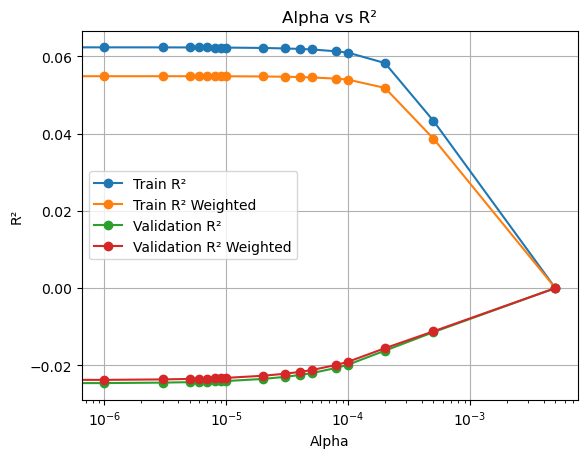

In [103]:
plt.plot(results_df['alpha'], results_df['train_r2'], marker='o', label='Train R²')
plt.plot(results_df['alpha'], results_df['train_r2_weighted'], marker='o', label='Train R² Weighted')
plt.plot(results_df['alpha'], results_df['val_r2'], marker='o', label='Validation R²')
plt.plot(results_df['alpha'], results_df['val_r2_weighted'], marker='o', label='Validation R² Weighted')
plt.xlabel('Alpha')
plt.ylabel('R²')
plt.title('Alpha vs R²')
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

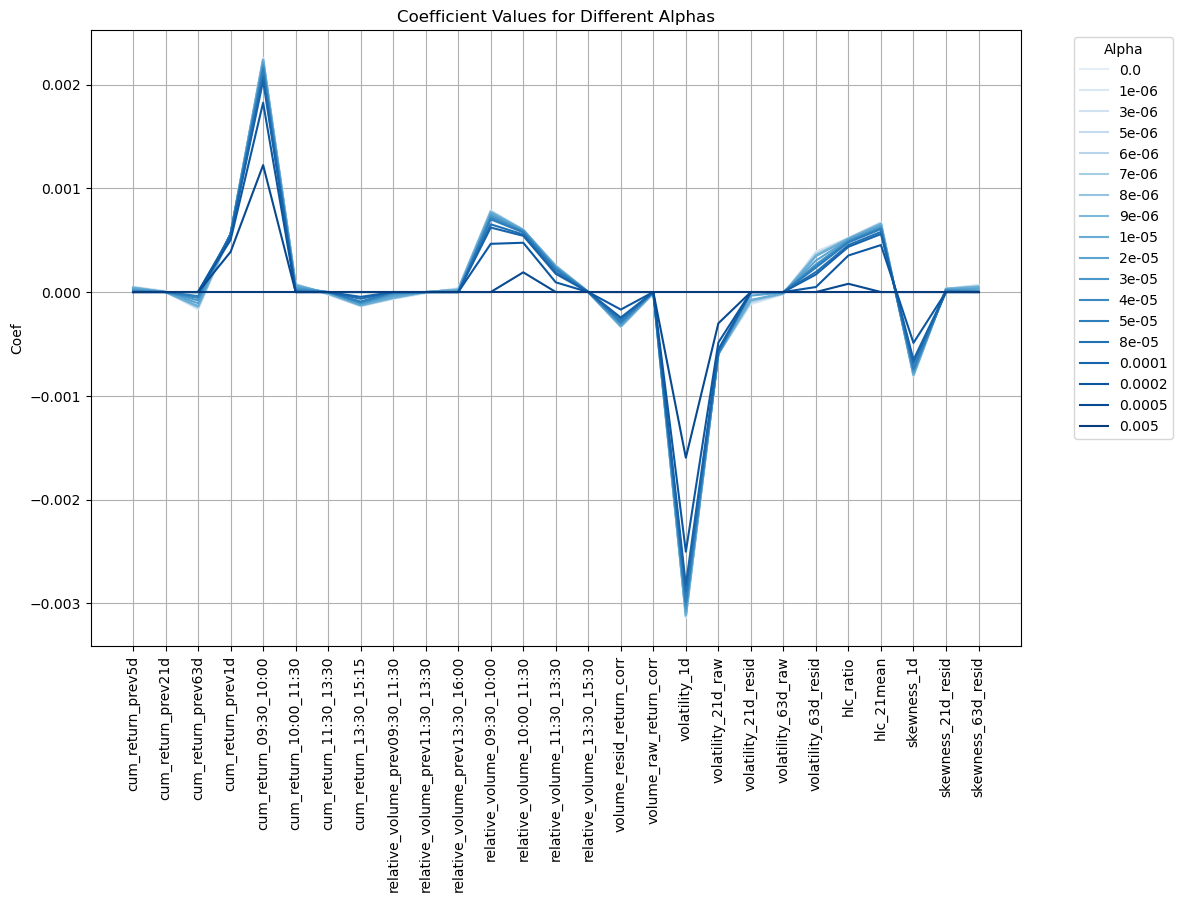

In [108]:
unique_alphas = results_df['alpha'].unique()
colors = [plt.cm.Blues((i+2)/20) for i in range(20)]

plt.figure(figsize=(12, 8))

for alpha, color in zip(unique_alphas, colors):
    subset = results_df[results_df['alpha'] == alpha]
    plt.plot(
        feature_cols, 
        subset[feature_cols].values.flatten(), 
        label=f'{alpha}', 
        color=color
    )

plt.ylabel('Coef')
plt.title('Coefficient Values for Different Alphas')
plt.xticks(rotation=90)
plt.legend(title='Alpha', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.show()

# Select features

Conclusion:

delete features: hlc_ratio, hlc_21mean

because hlc_ratio has the same meaning to volatility_1d, so does hlc_21mean to volatility_21d

# After select features

In [110]:
feature_cols = [
    'cum_return_prev5d','cum_return_prev21d','cum_return_prev63d','cum_return_prev1d',
    'cum_return_09:30_10:00','cum_return_10:00_11:30','cum_return_11:30_13:30',
    'cum_return_13:30_15:15','relative_volume_prev09:30_11:30', # 'relative_volume_15:30',
    'relative_volume_prev11:30_13:30','relative_volume_prev13:30_16:00',
    'relative_volume_09:30_10:00','relative_volume_10:00_11:30',
    'relative_volume_11:30_13:30','relative_volume_13:30_15:30',
    'volume_resid_return_corr','volume_raw_return_corr','volatility_1d',
    'volatility_21d_raw','volatility_21d_resid','volatility_63d_raw',
    'volatility_63d_resid','skewness_1d', # 'hlc_ratio','hlc_21mean',
    'skewness_21d_resid','skewness_63d_resid'
]
target_col = 'y'

In [ ]:
features_df = features_df[['Date', 'Id', 'y', 'weight'] + feature_cols]

## Save selected features

In [123]:
features_df.to_csv('data_features_df_selected.csv', index=False)

# Train-Test split

In [114]:
train_start = '2010-04-07'
train_end   = '2013-12-31'
val_start   = '2014-01-01'
val_end     = '2015-12-31'

X_train = features_df[features_df['Date'] < val_start][feature_cols]
y_train = features_df[features_df['Date'] < val_start]['y']
w_train = features_df[features_df['Date'] < val_start]['weight']

X_val = features_df[features_df['Date'] >= val_start][feature_cols]
y_val = features_df[features_df['Date'] >= val_start]['y']
w_val = features_df[features_df['Date'] >= val_start]['weight']

## normalization

In [115]:
pipeline = Pipeline([
    ('scaler', StandardScaler())  # Only normalization
])

X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)

## winsorization

In [ ]:
# TO DO

## evaluate function

In [116]:
def evaluate(model):
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # evaluate training set
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    train_r2_weighted = weighted_r2(y_train, y_train_pred, w_train)
    train_corr = pd.Series(y_train_pred, index=y_train.index).corr(y_train)
    train_corr_weighted = weighted_corr(y_train, y_train_pred, w_train)

    # evaluate validation set
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    val_r2_weighted = weighted_r2(y_val, y_val_pred, w_val)
    val_corr = pd.Series(y_val_pred, index=y_val.index).corr(y_val)
    val_corr_weighted = weighted_corr(y_val, y_val_pred, w_val)

    # results output
    if isinstance(model, LinearRegression):
        print("Linear Regression (alpha=0):")
    elif isinstance(model, Lasso):
        print(f"Lasso Regression (alpha={model.alpha}):")
    elif isinstance(model, Ridge):
        print(f"Ridge Regression (alpha={model.alpha}):")
    
    print(f"Train MSE: {train_mse:.8f}, Train R^2 Weighted: {train_r2_weighted:.8f}, Train R^2: {train_r2:.8f}, Train Corr Weighted: {train_corr_weighted:.8f}, Train Corr: {train_corr:.8f}")
    print(f"Val MSE:   {val_mse:.8f}, Val R^2 Weighted:   {val_r2_weighted:.8f}, Val R^2:   {val_r2:.8f}, Val Corr Weighted:   {val_corr_weighted:.8f}, Val Corr:   {val_corr:.8f}")
    print("Coefficients:")
    display(pd.DataFrame([model.coef_], columns=feature_cols))
    print("-" * 50)

    # results dictionary
    result = {
        'alpha': 0 if isinstance(model, LinearRegression) else model.alpha,
        'train_mse': train_mse,
        'train_r2_weighted': train_r2_weighted,
        'train_r2': train_r2,
        'train_corr_weighted': train_corr_weighted,
        'train_corr': train_corr,
        'val_mse': val_mse,
        'val_r2_weighted': val_r2_weighted,
        'val_r2': val_r2,
        'val_corr_weighted': val_corr_weighted,
        'val_corr': val_corr,
        **{f"{feature}": coef for feature, coef in zip(feature_cols, model.coef_)}
    }

    return result

# OLS

In [117]:
### 1. Linear Regression (alpha=0)
lr = LinearRegression()
lr.fit(X_train, y_train, sample_weight=w_train)

ols_result = evaluate(lr)

Linear Regression (alpha=0):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180159, Train R^2: 0.05859280, Train Corr Weighted: 0.22759963, Train Corr: 0.24230675
Val MSE:   0.00016698, Val R^2 Weighted:   -0.02582243, Val R^2:   -0.02655575, Val Corr Weighted:   0.01377071, Val Corr:   0.01152758
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.00005,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.00003,-0.000028,0.000025,0.0006,0.0007,0.000249,0.000106,-0.000344,-0.000023,-0.002799,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087


--------------------------------------------------


In [118]:
# output statistics
ols_model = sm.WLS(y_train, sm.add_constant(pd.DataFrame(X_train, columns=feature_cols)), weights=w_train)
ols_model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.052
Model:                            WLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     988.4
Date:                Tue, 11 Mar 2025   Prob (F-statistic):               0.00
Time:                        20:46:11   Log-Likelihood:             1.2619e+06
No. Observations:              452341   AIC:                        -2.524e+06
Df Residuals:                  452315   BIC:                        -2.523e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -8.247e-05   2.14e-05     -3.856      0.000      -0.000   -4.05e-05
cum_return_prev5d                5.029e-05   2.71e-05      1.853      0.064    -2.9e-06       0.000
cum_return_prev21d              -4.497e-05   3.16e-05     -1.423      0.155      -0.000     1.7e-05
cum_return_prev63d                 -0.0002   2.97e-05     -6.931      0.000      -0.000      -0.000
cum_return_prev1d                   0.0006   2.49e-05     24.654      0.000       0.001       0.001
cum_return_09:30_10:00              0.0023   2.77e-05     83.507      0.000       0.002       0.002
cum_return_10:00_11:30           7.786e-05   2.26e-05      3.447      0.001    3.36e-05       0.000
cum_return_11:30_13:30          -2.361e-05    2.2e-05     -1.074      0.283   -6.67e-05    1.95e-05
cum_return_13:30_15:15             -0.0002    2.2e-05     -6.928      0.000      -0.000      -0.000
relative_volume_prev09:30_11:30 -3.003e-05   2.49e-05     -1.207      0.227   -7.88e-05    1.87e-05
relative_volume_prev11:30_13:30 -2.808e-05   2.69e-05     -1.044      0.297   -8.08e-05    2.46e-05
relative_volume_prev13:30_16:00  2.468e-05   2.55e-05      0.968      0.333   -2.53e-05    7.47e-05
relative_volume_09:30_10:00         0.0006   3.47e-05     17.325      0.000       0.001       0.001
relative_volume_10:00_11:30         0.0007   4.05e-05     17.285      0.000       0.001       0.001
relative_volume_11:30_13:30         0.0002   3.56e-05      7.003      0.000       0.000       0.000
relative_volume_13:30_15:30         0.0001   3.09e-05      3.422      0.001    4.52e-05       0.000
volume_resid_return_corr           -0.0003   3.18e-05    -10.838      0.000      -0.000      -0.000
volume_raw_return_corr          -2.266e-05   2.48e-05     -0.915      0.360   -7.12e-05    2.59e-05
volatility_1d                      -0.0028   2.86e-05    -97.899      0.000      -0.003      -0.003
volatility_21d_raw                 -0.0006    2.5e-05    -23.543      0.000      -0.001      -0.001
volatility_21d_resid                0.0001   3.36e-05      4.380      0.000    8.14e-05       0.000
volatility_63d_raw               -1.12e-05   2.03e-05     -0.553      0.580   -5.09e-05    2.85e-05
volatility_63d_resid                0.0006   3.29e-05     19.527      0.000       0.001       0.001
skewness_1d                        -0.0008   3.16e-05    -26.019      0.000      -0.001      -0.001
skewness_21d_resid               4.385e-05    2.8e-05      1.567      0.117    -1.1e-05    9.87e-05
skewness_63d_resid               8.695e-05    2.9e-05      3.001      0.003    3.02e-05       0.000
==============================================================================
Omnibus:                   677464.258   Durbin-Watson:                   1.997
Prob(Omnibus):           

# Lasso

## training - grid search

In [119]:
# Store all results
results = [ols_result]

In [120]:
for alpha in [1e-6, 3e-6, 5e-6, 6e-6, 7e-6, 8e-6, 9e-6, 1e-5, 2e-5, 3e-5, 4e-5, 5e-5, 8e-5, 1e-4, 2e-4, 5e-4, 1e-3]:
    lasso = Lasso(alpha=alpha) #, max_iter=10000)  # 设置 max_iter 确保收敛
    lasso.fit(X_train, y_train, sample_weight=w_train)
    
    result = evaluate(lasso)
    results.append(result)

Lasso Regression (alpha=1e-06):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180144, Train R^2: 0.05858999, Train Corr Weighted: 0.22759940, Train Corr: 0.24231068
Val MSE:   0.00016697, Val R^2 Weighted:   -0.02576264, Val R^2:   -0.02649541, Val Corr Weighted:   0.01377773, Val Corr:   0.01153064
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000049,-0.000043,-0.000204,0.000613,0.002309,0.000076,-0.000023,-0.000151,-0.000029,-0.000026,0.000023,0.000599,0.0007,0.000248,0.000105,-0.000344,-0.000022,-0.002796,-0.000588,0.000146,-0.000011,0.000641,-0.000821,0.000043,0.000085


--------------------------------------------------
Lasso Regression (alpha=3e-06):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180024, Train R^2: 0.05858342, Train Corr Weighted: 0.22759759, Train Corr: 0.24231722
Val MSE:   0.00016695, Val R^2 Weighted:   -0.02564273, Val R^2:   -0.02637436, Val Corr Weighted:   0.01379252, Val Corr:   0.01153750
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000045,-0.000038,-0.000201,0.000613,0.002304,0.000074,-0.00002,-0.00015,-0.000027,-0.000023,0.000019,0.000596,0.000698,0.000247,0.000104,-0.000342,-0.000021,-0.00279,-0.000587,0.000142,-0.00001,0.000639,-0.000818,0.00004,0.000082


--------------------------------------------------
Lasso Regression (alpha=5e-06):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05179782, Train R^2: 0.05857564, Train Corr Weighted: 0.22759392, Train Corr: 0.24232196
Val MSE:   0.00016693, Val R^2 Weighted:   -0.02552426, Val R^2:   -0.02625481, Val Corr Weighted:   0.01380721, Val Corr:   0.01154425
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000042,-0.000033,-0.000198,0.000612,0.002299,0.000071,-0.000018,-0.000148,-0.000024,-0.00002,0.000015,0.000593,0.000697,0.000246,0.000103,-0.00034,-0.000019,-0.002784,-0.000586,0.000139,-0.000009,0.000636,-0.000815,0.000037,0.000079


--------------------------------------------------
Lasso Regression (alpha=6e-06):
Train MSE: 0.00021225, Train R^2 Weighted: 0.05179616, Train R^2: 0.05857124, Train Corr Weighted: 0.22759140, Train Corr: 0.24232356
Val MSE:   0.00016692, Val R^2 Weighted:   -0.02546479, Val R^2:   -0.02619467, Val Corr Weighted:   0.01381469, Val Corr:   0.01154787
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.00004,-0.00003,-0.000197,0.000612,0.002296,0.000069,-0.000017,-0.000147,-0.000023,-0.000018,0.000013,0.000592,0.000696,0.000245,0.000102,-0.000339,-0.000018,-0.002781,-0.000586,0.000137,-0.000008,0.000635,-0.000814,0.000036,0.000077


--------------------------------------------------
Lasso Regression (alpha=7e-06):
Train MSE: 0.00021225, Train R^2 Weighted: 0.05179419, Train R^2: 0.05856658, Train Corr Weighted: 0.22758840, Train Corr: 0.24232477
Val MSE:   0.00016691, Val R^2 Weighted:   -0.02540638, Val R^2:   -0.02613572, Val Corr Weighted:   0.01382192, Val Corr:   0.01155113
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000039,-0.000028,-0.000195,0.000612,0.002294,0.000068,-0.000016,-0.000146,-0.000022,-0.000017,0.000011,0.000591,0.000695,0.000244,0.000102,-0.000338,-0.000018,-0.002778,-0.000585,0.000136,-0.000007,0.000634,-0.000812,0.000035,0.000076


--------------------------------------------------
Lasso Regression (alpha=8e-06):
Train MSE: 0.00021225, Train R^2 Weighted: 0.05179192, Train R^2: 0.05856162, Train Corr Weighted: 0.22758492, Train Corr: 0.24232551
Val MSE:   0.00016690, Val R^2 Weighted:   -0.02534832, Val R^2:   -0.02607711, Val Corr Weighted:   0.01382909, Val Corr:   0.01155433
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000037,-0.000025,-0.000194,0.000612,0.002292,0.000066,-0.000015,-0.000145,-0.000021,-0.000015,0.00001,0.000589,0.000695,0.000243,0.000101,-0.000337,-0.000017,-0.002775,-0.000585,0.000134,-0.000007,0.000632,-0.00081,0.000033,0.000074


--------------------------------------------------
Lasso Regression (alpha=9e-06):
Train MSE: 0.00021225, Train R^2 Weighted: 0.05178934, Train R^2: 0.05855636, Train Corr Weighted: 0.22758096, Train Corr: 0.24232578
Val MSE:   0.00016689, Val R^2 Weighted:   -0.02529058, Val R^2:   -0.02601884, Val Corr Weighted:   0.01383621, Val Corr:   0.01155749
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000036,-0.000023,-0.000192,0.000612,0.002289,0.000065,-0.000014,-0.000144,-0.00002,-0.000013,0.000008,0.000588,0.000694,0.000243,0.0001,-0.000336,-0.000016,-0.002772,-0.000585,0.000132,-0.000006,0.000631,-0.000809,0.000032,0.000073


--------------------------------------------------
Lasso Regression (alpha=1e-05):
Train MSE: 0.00021225, Train R^2 Weighted: 0.05178646, Train R^2: 0.05855078, Train Corr Weighted: 0.22757653, Train Corr: 0.24232557
Val MSE:   0.00016688, Val R^2 Weighted:   -0.02523318, Val R^2:   -0.02596089, Val Corr Weighted:   0.01384329, Val Corr:   0.01156060
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000034,-0.000021,-0.000191,0.000612,0.002287,0.000063,-0.000013,-0.000143,-0.000019,-0.000012,0.000006,0.000586,0.000693,0.000242,0.0001,-0.000335,-0.000016,-0.002769,-0.000584,0.000131,-0.000006,0.00063,-0.000807,0.000031,0.000071


--------------------------------------------------
Lasso Regression (alpha=2e-05):
Train MSE: 0.00021227, Train R^2 Weighted: 0.05174440, Train R^2: 0.05847832, Train Corr Weighted: 0.22751297, Train Corr: 0.24229616
Val MSE:   0.00016679, Val R^2 Weighted:   -0.02467622, Val R^2:   -0.02539801, Val Corr Weighted:   0.01391027, Val Corr:   0.01159491
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000019,-0.0,-0.000174,0.000611,0.002262,0.000049,-0.000002,-0.000134,-0.000009,-1.888972e-08,0.0,0.000572,0.000685,0.000235,0.000092,-0.000326,-0.000009,-0.00274,-0.00058,0.000115,-6.956690e-07,0.000618,-0.000792,0.000019,0.000055


--------------------------------------------------
Lasso Regression (alpha=3e-05):
Train MSE: 0.00021229, Train R^2 Weighted: 0.05168658, Train R^2: 0.05838628, Train Corr Weighted: 0.22743193, Train Corr: 0.24224043
Val MSE:   0.00016671, Val R^2 Weighted:   -0.02415956, Val R^2:   -0.02487666, Val Corr Weighted:   0.01394049, Val Corr:   0.01159923
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000009,-0.0,-0.000147,0.000609,0.002238,0.000034,-0.0,-0.000126,-0.0,-0.0,0.0,0.000557,0.000678,0.000229,0.000083,-0.000318,-9.984371e-07,-0.002711,-0.000574,0.000101,-0.0,0.000606,-0.000777,0.000016,0.000035


--------------------------------------------------
Lasso Regression (alpha=4e-05):
Train MSE: 0.00021231, Train R^2 Weighted: 0.05161091, Train R^2: 0.05827578, Train Corr Weighted: 0.22732739, Train Corr: 0.24215950
Val MSE:   0.00016663, Val R^2 Weighted:   -0.02367270, Val R^2:   -0.02438905, Val Corr Weighted:   0.01393729, Val Corr:   0.01156630
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,-0.0,-0.00012,0.000608,0.002214,0.00002,-0.0,-0.000116,-0.0,-0.0,0.0,0.000544,0.000671,0.000223,0.000074,-0.000306,-0.0,-0.002682,-0.000567,0.000087,-0.0,0.000595,-0.000762,0.000012,0.000014


--------------------------------------------------
Lasso Regression (alpha=5e-05):
Train MSE: 0.00021234, Train R^2 Weighted: 0.05151878, Train R^2: 0.05814979, Train Corr Weighted: 0.22720110, Train Corr: 0.24205935
Val MSE:   0.00016655, Val R^2 Weighted:   -0.02321107, Val R^2:   -0.02392157, Val Corr Weighted:   0.01391732, Val Corr:   0.01153206
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,-0.0,-0.000098,0.000603,0.00219,0.000005,-0.0,-0.000107,-0.0,-0.0,0.0,0.000531,0.000665,0.000217,0.000066,-0.000293,-0.0,-0.002653,-0.00056,0.000073,-0.0,0.000584,-0.000747,0.000004,0.0


--------------------------------------------------
Lasso Regression (alpha=8e-05):
Train MSE: 0.00021244, Train R^2 Weighted: 0.05120310, Train R^2: 0.05771049, Train Corr Weighted: 0.22682188, Train Corr: 0.24170776
Val MSE:   0.00016633, Val R^2 Weighted:   -0.02187090, Val R^2:   -0.02255025, Val Corr Weighted:   0.01395914, Val Corr:   0.01157523
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,-0.0,-0.000056,0.000587,0.002123,0.0,-0.0,-0.000079,-0.0,-0.0,0.0,0.000491,0.000643,0.000202,0.00004,-0.000269,-0.0,-0.002566,-0.000538,0.000031,-0.0,0.00055,-0.000697,0.0,0.0


--------------------------------------------------
Lasso Regression (alpha=0.0001):
Train MSE: 0.00021252, Train R^2 Weighted: 0.05091677, Train R^2: 0.05733858, Train Corr Weighted: 0.22646002, Train Corr: 0.24135963
Val MSE:   0.00016619, Val R^2 Weighted:   -0.02104545, Val R^2:   -0.02170278, Val Corr Weighted:   0.01397760, Val Corr:   0.01160116
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,-0.0,-0.000029,0.000576,0.002078,0.0,-0.0,-0.00006,-0.0,-0.0,0.0,0.000465,0.000628,0.000192,0.000023,-0.000253,-0.0,-0.002508,-0.000523,0.000004,-0.0,0.000528,-0.000663,0.0,0.0


--------------------------------------------------
Lasso Regression (alpha=0.0002):
Train MSE: 0.00021307, Train R^2 Weighted: 0.04895924, Train R^2: 0.05493012, Train Corr Weighted: 0.22402509, Train Corr: 0.23893872
Val MSE:   0.00016558, Val R^2 Weighted:   -0.01741513, Val R^2:   -0.01794413, Val Corr Weighted:   0.01432100, Val Corr:   0.01200767
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,-0.0,-0.0,0.000531,0.001859,0.0,-0.0,-0.0,0.0,0.0,0.0,0.000337,0.000548,0.000116,0.0,-0.000175,-0.0,-0.002244,-0.000463,0.0,-0.0,0.000338,-0.000498,0.0,0.0


--------------------------------------------------
Lasso Regression (alpha=0.0005):
Train MSE: 0.00021581, Train R^2 Weighted: 0.03822641, Train R^2: 0.04277288, Train Corr Weighted: 0.20421783, Train Corr: 0.21889857
Val MSE:   0.00016456, Val R^2 Weighted:   -0.01149650, Val R^2:   -0.01168137, Val Corr Weighted:   0.01481194, Val Corr:   0.01298753
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,0.0,0.0,0.000391,0.001225,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.000201,0.0,0.0,-0.0,-0.0,-0.001563,-0.000299,0.0,-0.0,0.0,-0.0,0.0,0.0


--------------------------------------------------
Lasso Regression (alpha=0.001):
Train MSE: 0.00021880, Train R^2 Weighted: 0.02634257, Train R^2: 0.02947678, Train Corr Weighted: 0.18789214, Train Corr: 0.20274516
Val MSE:   0.00016356, Val R^2 Weighted:   -0.00542308, Val R^2:   -0.00554149, Val Corr Weighted:   0.01037990, Val Corr:   0.00909955
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.0,0.0,0.0,0.000002,0.000812,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.00108,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0


--------------------------------------------------


In [121]:
results_df = pd.DataFrame(results)
results_df = results_df.drop_duplicates()
results_df = results_df.sort_values(by='alpha').reset_index(drop=True)
results_df

,alpha,train_mse,train_r2_weighted,train_r2,train_corr_weighted,train_corr,val_mse,val_r2_weighted,val_r2,val_corr_weighted,val_corr,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000000,0.000212,0.051802,0.058593,0.227600,0.242307,0.000167,-0.025822,-0.026556,0.013771,0.011528,0.000050,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.000030,-2.808446e-05,0.000025,0.000600,0.000700,0.000249,0.000106,-0.000344,-2.265527e-05,-0.002799,-0.000588,0.000147,-1.119598e-05,0.000642,-0.000823,0.000044,0.000087
1,0.000001,0.000212,0.051801,0.058590,0.227599,0.242311,0.000167,-0.025763,-0.026495,0.013778,0.011531,0.000049,-0.000043,-0.000204,0.000613,0.002309,0.000076,-0.000023,-0.000151,-0.000029,-2.644229e-05,0.000023,0.000599,0.000700,0.000248,0.000105,-0.000344,-2.195856e-05,-0.002796,-0.000588,0.000146,-1.065442e-05,0.000641,-0.000821,0.000043,0.000085
2,0.000003,0.000212,0.051800,0.058583,0.227598,0.242317,0.000167,-0.025643,-0.026374,0.013793,0.011538,0.000045,-0.000038,-0.000201,0.000613,0.002304,0.000074,-0.000020,-0.000150,-0.000027,-2.314494e-05,0.000019,0.000596,0.000698,0.000247,0.000104,-0.000342,-2.056598e-05,-0.002790,-0.000587,0.000142,-9.600835e-06,0.000639,-0.000818,0.000040,0.000082
3,0.000005,0.000212,0.051798,0.058576,0.227594,0.242322,0.000167,-0.025524,-0.026255,0.013807,0.011544,0.000042,-0.000033,-0.000198,0.000612,0.002299,0.000071,-0.000018,-0.000148,-0.000024,-1.985180e-05,0.000015,0.000593,0.000697,0.000246,0.000103,-0.000340,-1.917102e-05,-0.002784,-0.000586,0.000139,-8.561138e-06,0.000636,-0.000815,0.000037,0.000079
4,0.000006,0.000212,0.051796,0.058571,0.227591,0.242324,0.000167,-0.025465,-0.026195,0.013815,0.011548,0.000040,-0.000030,-0.000197,0.000612,0.002296,0.000069,-0.000017,-0.000147,-0.000023,-1.819202e-05,0.000013,0.000592,0.000696,0.000245,0.000102,-0.000339,-1.847751e-05,-0.002781,-0.000586,0.000137,-8.019537e-06,0.000635,-0.000814,0.000036,0.000077
5,0.000007,0.000212,0.051794,0.058567,0.227588,0.242325,0.000167,-0.025406,-0.026136,0.013822,0.011551,0.000039,-0.000028,-0.000195,0.000612,0.002294,0.000068,-0.000016,-0.000146,-0.000022,-1.654546e-05,0.000011,0.000591,0.000695,0.000244,0.000102,-0.000338,-1.777999e-05,-0.002778,-0.000585,0.000136,-7.499789e-06,0.000634,-0.000812,0.000035,0.000076
6,0.000008,0.000212,0.051792,0.058562,0.227585,0.242326,0.000167,-0.025348,-0.026077,0.013829,0.011554,0.000037,-0.000025,-0.000194,0.000612,0.002292,0.000066,-0.000015,-0.000145,-0.000021,-1.489897e-05,0.000010,0.000589,0.000695,0.000243,0.000101,-0.000337,-1.708250e-05,-0.002775,-0.000585,0.000134,-6.979968e-06,0.000632,-0.000810,0.000033,0.000074
7,0.000009,0.000212,0.051789,0.058556,0.227581,0.242326,0.000167,-0.025291,-0.026019,0.013836,0.011557,0.000036,-0.000023,-0.000192,0.000612,0.002289,0.000065,-0.000014,-0.000144,-0.000020,-1.325246e-05,0.000008,0.000588,0.000694,0.000243,0.000100,-0.000336,-1.638500e-05,-0.002772,-0.000585,0.000132,-6.460154e-06,0.000631,-0.000809,0.000032,0.000073
8,0.000010,0.000212,0.051786,0.058551,0.227577,0.242326,0.000167,-0.025233,-0.025961,0.013843,0.011561,0.000034,-0.000021,-0.000191,0.000612,0.002287,0.000063,-0.000013,-0.000143,-0.000019,-1.160595e-05,0.000006,0.000586,0.000693,0.000242,0.000100,-0.000335,-1.568751e-05,-0.002769,-0.000584,0.000131,-5.940332e-06,0.000630,-0.000807,0.000031,0.000071
9,0.000020,0.000212,0.051744,0.058478,0.227513,0.242296,0.000167,-0.024676,-0.025398,0.013910,0.011595,0.000019,-0.000000,-0.000174,0

In [122]:
results_df.to_csv("lasso_regression_results.csv", index=False)

## plot

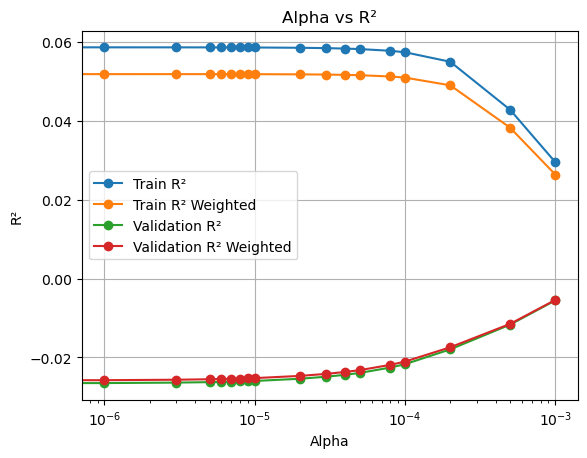

In [125]:
plt.plot(results_df['alpha'], results_df['train_r2'], marker='o', label='Train R²')
plt.plot(results_df['alpha'], results_df['train_r2_weighted'], marker='o', label='Train R² Weighted')
plt.plot(results_df['alpha'], results_df['val_r2'], marker='o', label='Validation R²')
plt.plot(results_df['alpha'], results_df['val_r2_weighted'], marker='o', label='Validation R² Weighted')
plt.xlabel('Alpha')
plt.ylabel('R²')
plt.title('Alpha vs R²')
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

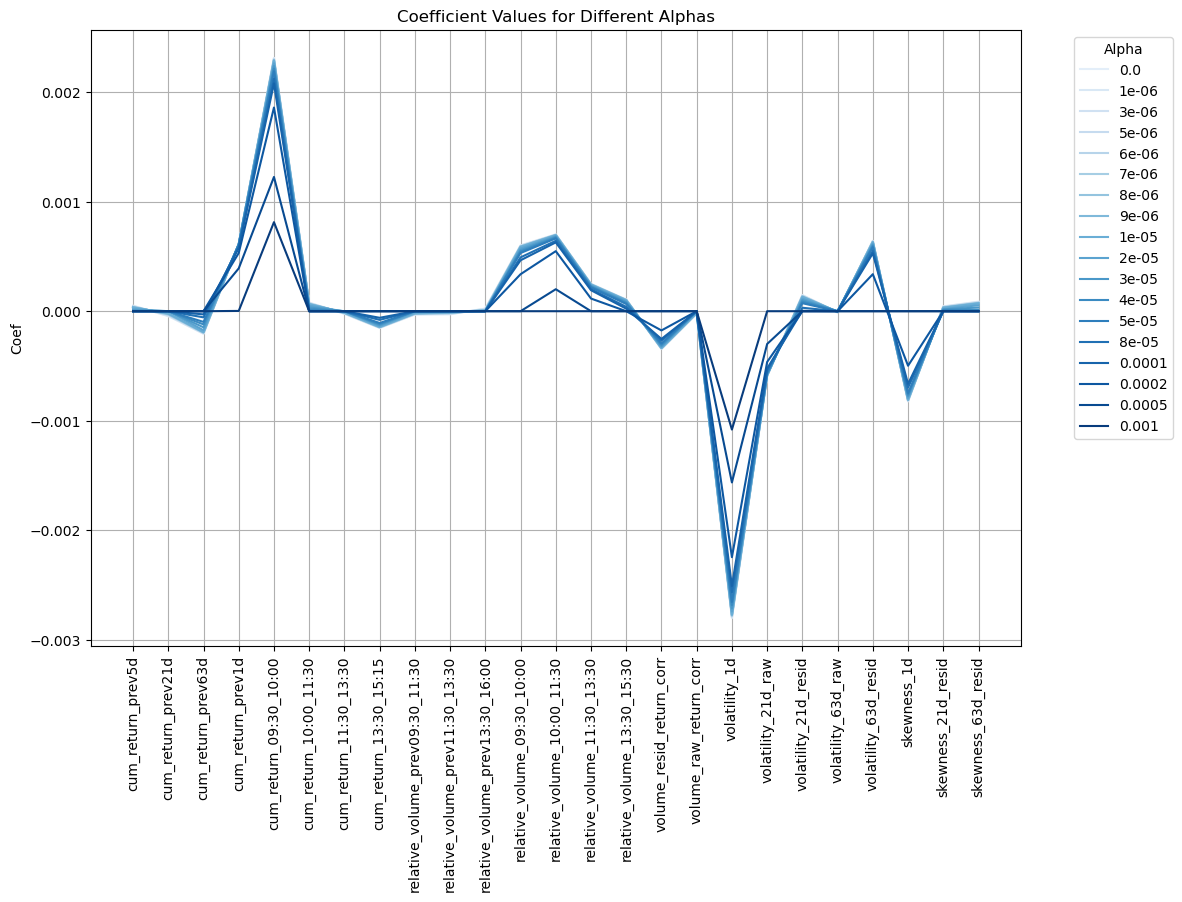

In [126]:
unique_alphas = results_df['alpha'].unique()
colors = [plt.cm.Blues((i+2)/20) for i in range(20)]

plt.figure(figsize=(12, 8))

for alpha, color in zip(unique_alphas, colors):
    subset = results_df[results_df['alpha'] == alpha]
    plt.plot(
        feature_cols, 
        subset[feature_cols].values.flatten(), 
        label=f'{alpha}', 
        color=color
    )

plt.ylabel('Coef')
plt.title('Coefficient Values for Different Alphas')
plt.xticks(rotation=90)
plt.legend(title='Alpha', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.show()

# Ridge

In [132]:
alphas = [1e4, 2e4, 5e4, 1e5, 2e5, 5e5, 1e6, 5e6, 1e7, 5e7, 1e8, 5e8, 1e9, 5e9, 1e10]

ridge_results = [ols_result]

In [133]:
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train, sample_weight=w_train)
    
    result = evaluate(ridge)
    ridge_results.append(result)

Ridge Regression (alpha=10000.0):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180159, Train R^2: 0.05859278, Train Corr Weighted: 0.22759963, Train Corr: 0.24230675
Val MSE:   0.00016698, Val R^2 Weighted:   -0.02582226, Val R^2:   -0.02655558, Val Corr Weighted:   0.01377074, Val Corr:   0.01152760
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.00005,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.00003,-0.000028,0.000025,0.0006,0.0007,0.000249,0.000106,-0.000344,-0.000023,-0.002799,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087


--------------------------------------------------
Ridge Regression (alpha=20000.0):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180159, Train R^2: 0.05859277, Train Corr Weighted: 0.22759963, Train Corr: 0.24230674
Val MSE:   0.00016698, Val R^2 Weighted:   -0.02582209, Val R^2:   -0.02655541, Val Corr Weighted:   0.01377076, Val Corr:   0.01152763
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.00005,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.00003,-0.000028,0.000025,0.0006,0.0007,0.000249,0.000106,-0.000344,-0.000023,-0.002799,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087


--------------------------------------------------
Ridge Regression (alpha=50000.0):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180159, Train R^2: 0.05859273, Train Corr Weighted: 0.22759963, Train Corr: 0.24230673
Val MSE:   0.00016698, Val R^2 Weighted:   -0.02582159, Val R^2:   -0.02655490, Val Corr Weighted:   0.01377084, Val Corr:   0.01152770
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.00005,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.00003,-0.000028,0.000025,0.0006,0.0007,0.000249,0.000106,-0.000344,-0.000023,-0.002798,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087


--------------------------------------------------
Ridge Regression (alpha=100000.0):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180159, Train R^2: 0.05859266, Train Corr Weighted: 0.22759963, Train Corr: 0.24230670
Val MSE:   0.00016698, Val R^2 Weighted:   -0.02582075, Val R^2:   -0.02655405, Val Corr Weighted:   0.01377096, Val Corr:   0.01152781
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.00005,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.00003,-0.000028,0.000025,0.0006,0.0007,0.000249,0.000106,-0.000344,-0.000023,-0.002798,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087


--------------------------------------------------
Ridge Regression (alpha=200000.0):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180159, Train R^2: 0.05859251, Train Corr Weighted: 0.22759963, Train Corr: 0.24230664
Val MSE:   0.00016698, Val R^2 Weighted:   -0.02581907, Val R^2:   -0.02655235, Val Corr Weighted:   0.01377121, Val Corr:   0.01152804
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.00005,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.00003,-0.000028,0.000025,0.0006,0.0007,0.000249,0.000106,-0.000344,-0.000023,-0.002798,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087


--------------------------------------------------
Ridge Regression (alpha=500000.0):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180159, Train R^2: 0.05859208, Train Corr Weighted: 0.22759963, Train Corr: 0.24230647
Val MSE:   0.00016698, Val R^2 Weighted:   -0.02581404, Val R^2:   -0.02654725, Val Corr Weighted:   0.01377197, Val Corr:   0.01152874
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.00005,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.00003,-0.000028,0.000025,0.0006,0.0007,0.000249,0.000106,-0.000344,-0.000023,-0.002798,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087


--------------------------------------------------
Ridge Regression (alpha=1000000.0):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180159, Train R^2: 0.05859136, Train Corr Weighted: 0.22759962, Train Corr: 0.24230619
Val MSE:   0.00016698, Val R^2 Weighted:   -0.02580565, Val R^2:   -0.02653876, Val Corr Weighted:   0.01377322, Val Corr:   0.01152989
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.00005,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.00003,-0.000028,0.000025,0.0006,0.0007,0.000249,0.000106,-0.000344,-0.000023,-0.002798,-0.000588,0.000147,-0.000011,0.000642,-0.000822,0.000044,0.000087


--------------------------------------------------
Ridge Regression (alpha=5000000.0):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180148, Train R^2: 0.05858555, Train Corr Weighted: 0.22759957, Train Corr: 0.24230391
Val MSE:   0.00016697, Val R^2 Weighted:   -0.02573870, Val R^2:   -0.02647098, Val Corr Weighted:   0.01378323, Val Corr:   0.01153913
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000051,-0.000045,-0.000205,0.000613,0.002308,0.000078,-0.000024,-0.000152,-0.00003,-0.000028,0.000025,0.000599,0.000698,0.000249,0.000106,-0.000344,-0.000023,-0.002794,-0.000589,0.000147,-0.000011,0.000641,-0.00082,0.000044,0.000087


--------------------------------------------------
Ridge Regression (alpha=10000000.0):
Train MSE: 0.00021224, Train R^2 Weighted: 0.05180117, Train R^2: 0.05857812, Train Corr Weighted: 0.22759941, Train Corr: 0.24230096
Val MSE:   0.00016695, Val R^2 Weighted:   -0.02565545, Val R^2:   -0.02638668, Val Corr Weighted:   0.01379569, Val Corr:   0.01155065
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000051,-0.000045,-0.000205,0.000613,0.002304,0.000077,-0.000023,-0.000152,-0.00003,-0.000028,0.000025,0.000597,0.000697,0.000249,0.000106,-0.000344,-0.000023,-0.002789,-0.000589,0.000147,-0.000011,0.000639,-0.000818,0.000044,0.000086


--------------------------------------------------
Ridge Regression (alpha=50000000.0):
Train MSE: 0.00021226, Train R^2 Weighted: 0.05179140, Train R^2: 0.05851197, Train Corr Weighted: 0.22759432, Train Corr: 0.24227390
Val MSE:   0.00016685, Val R^2 Weighted:   -0.02500622, Val R^2:   -0.02572920, Val Corr Weighted:   0.01389372, Val Corr:   0.01164139
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000053,-0.000044,-0.0002,0.000615,0.002277,0.000075,-0.000023,-0.000152,-0.000028,-0.000027,0.000025,0.000586,0.000681,0.00025,0.000106,-0.000342,-0.000024,-0.002753,-0.00059,0.000144,-0.000013,0.000626,-0.000798,0.000044,0.000085


--------------------------------------------------
Ridge Regression (alpha=100000000.0):
Train MSE: 0.00021228, Train R^2 Weighted: 0.05176229, Train R^2: 0.05841384, Train Corr Weighted: 0.22757896, Train Corr: 0.24223185
Val MSE:   0.00016672, Val R^2 Weighted:   -0.02423452, Val R^2:   -0.02494747, Val Corr Weighted:   0.01401212, Val Corr:   0.01175150
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000055,-0.000044,-0.000195,0.000617,0.002244,0.000072,-0.000022,-0.000152,-0.000027,-0.000026,0.000026,0.000571,0.000663,0.00025,0.000106,-0.000339,-0.000025,-0.00271,-0.000592,0.000141,-0.000014,0.00061,-0.000775,0.000043,0.000082


--------------------------------------------------
Ridge Regression (alpha=500000000.0):
Train MSE: 0.00021255, Train R^2 Weighted: 0.05104647, Train R^2: 0.05719803, Train Corr Weighted: 0.22717558, Train Corr: 0.24164053
Val MSE:   0.00016591, Val R^2 Weighted:   -0.01931339, Val R^2:   -0.01995474, Val Corr Weighted:   0.01481710, Val Corr:   0.01251539
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000071,-0.000037,-0.00016,0.000622,0.002015,0.00005,-0.000019,-0.000148,-0.000018,-0.00002,0.000029,0.000474,0.000548,0.000244,0.000105,-0.000313,-0.000031,-0.002411,-0.000596,0.000114,-0.000027,0.000506,-0.000624,0.000041,0.000068


--------------------------------------------------
Ridge Regression (alpha=1000000000.0):
Train MSE: 0.00021302, Train R^2 Weighted: 0.04951628, Train R^2: 0.05514914, Train Corr Weighted: 0.22622681, Train Corr: 0.24050414
Val MSE:   0.00016523, Val R^2 Weighted:   -0.01522227, Val R^2:   -0.01579100, Val Corr Weighted:   0.01555152, Val Corr:   0.01323952
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000088,-0.000027,-0.00013,0.000615,0.001794,0.00003,-0.000015,-0.000144,-0.00001,-0.000013,0.000032,0.000386,0.000448,0.000227,0.0001,-0.000278,-0.000035,-0.002126,-0.000588,0.000083,-0.000041,0.000412,-0.000494,0.000038,0.000057


--------------------------------------------------
Ridge Regression (alpha=5000000000.0):
Train MSE: 0.00021631, Train R^2 Weighted: 0.03710067, Train R^2: 0.04055222, Train Corr Weighted: 0.21620392, Train Corr: 0.22969629
Val MSE:   0.00016350, Val R^2 Weighted:   -0.00483592, Val R^2:   -0.00512884, Val Corr Weighted:   0.01736383, Val Corr:   0.01531866
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.00013,0.000019,-0.000038,0.000478,0.000997,-0.000022,-0.000006,-0.00011,0.000004,0.000004,0.000032,0.000129,0.000165,0.000119,0.000058,-0.000117,-0.000023,-0.001141,-0.000457,-0.000028,-0.000097,0.000126,-0.000137,0.000029,0.00003


--------------------------------------------------
Ridge Regression (alpha=10000000000.0):
Train MSE: 0.00021855, Train R^2 Weighted: 0.02821902, Train R^2: 0.03058753, Train Corr Weighted: 0.20746467, Train Corr: 0.22050105
Val MSE:   0.00016302, Val R^2 Weighted:   -0.00204490, Val R^2:   -0.00222939, Val Corr Weighted:   0.01741545, Val Corr:   0.01565267
Coefficients:


,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000122,0.000033,-0.000009,0.000358,0.000661,-0.000025,-0.000004,-0.000081,0.000003,0.000006,0.000026,0.000056,0.00008,0.000066,0.000031,-0.000052,-0.000008,-0.000746,-0.000345,-0.000055,-0.000104,0.000039,-0.000044,0.000028,0.000025


--------------------------------------------------


In [134]:
ridge_results_df = pd.DataFrame(ridge_results)
ridge_results_df

,alpha,train_mse,train_r2_weighted,train_r2,train_corr_weighted,train_corr,val_mse,val_r2_weighted,val_r2,val_corr_weighted,val_corr,cum_return_prev5d,cum_return_prev21d,cum_return_prev63d,cum_return_prev1d,cum_return_09:30_10:00,cum_return_10:00_11:30,cum_return_11:30_13:30,cum_return_13:30_15:15,relative_volume_prev09:30_11:30,relative_volume_prev11:30_13:30,relative_volume_prev13:30_16:00,relative_volume_09:30_10:00,relative_volume_10:00_11:30,relative_volume_11:30_13:30,relative_volume_13:30_15:30,volume_resid_return_corr,volume_raw_return_corr,volatility_1d,volatility_21d_raw,volatility_21d_resid,volatility_63d_raw,volatility_63d_resid,skewness_1d,skewness_21d_resid,skewness_63d_resid
0,0.000000e+00,0.000212,0.051802,0.058593,0.227600,0.242307,0.000167,-0.025822,-0.026556,0.013771,0.011528,0.000050,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.000030,-0.000028,0.000025,0.000600,0.000700,0.000249,0.000106,-0.000344,-0.000023,-0.002799,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087
1,1.000000e+04,0.000212,0.051802,0.058593,0.227600,0.242307,0.000167,-0.025822,-0.026556,0.013771,0.011528,0.000050,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.000030,-0.000028,0.000025,0.000600,0.000700,0.000249,0.000106,-0.000344,-0.000023,-0.002799,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087
2,2.000000e+04,0.000212,0.051802,0.058593,0.227600,0.242307,0.000167,-0.025822,-0.026555,0.013771,0.011528,0.000050,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.000030,-0.000028,0.000025,0.000600,0.000700,0.000249,0.000106,-0.000344,-0.000023,-0.002799,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087
3,5.000000e+04,0.000212,0.051802,0.058593,0.227600,0.242307,0.000167,-0.025822,-0.026555,0.013771,0.011528,0.000050,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.000030,-0.000028,0.000025,0.000600,0.000700,0.000249,0.000106,-0.000344,-0.000023,-0.002798,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087
4,1.000000e+05,0.000212,0.051802,0.058593,0.227600,0.242307,0.000167,-0.025821,-0.026554,0.013771,0.011528,0.000050,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.000030,-0.000028,0.000025,0.000600,0.000700,0.000249,0.000106,-0.000344,-0.000023,-0.002798,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087
5,2.000000e+05,0.000212,0.051802,0.058593,0.227600,0.242307,0.000167,-0.025819,-0.026552,0.013771,0.011528,0.000050,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.000030,-0.000028,0.000025,0.000600,0.000700,0.000249,0.000106,-0.000344,-0.000023,-0.002798,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087
6,5.000000e+05,0.000212,0.051802,0.058592,0.227600,0.242306,0.000167,-0.025814,-0.026547,0.013772,0.011529,0.000050,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.000030,-0.000028,0.000025,0.000600,0.000700,0.000249,0.000106,-0.000344,-0.000023,-0.002798,-0.000588,0.000147,-0.000011,0.000642,-0.000823,0.000044,0.000087
7,1.000000e+06,0.000212,0.051802,0.058591,0.227600,0.242306,0.000167,-0.025806,-0.026539,0.013773,0.011530,0.000050,-0.000045,-0.000206,0.000613,0.002311,0.000078,-0.000024,-0.000152,-0.000030,-0.000028,0.000025,0.000600,0.000700,0.000249,0.000106,-0.000344,-0.000023,-0.002798,-0.000588,0.000147,-0.000011,0.000642,-0.000822,0.000044,0.000087
8,5.000000e+06,0.000212,0.051801,0.058586,0.227600,0.242304,0.000167,-0.025739,-0.026471,0.013783,0.011539,0.000051,-0.000045,-0.000205,0.000613,0.002308,0.000078,-0.000024,-0.000152,-0.000030,-0.000028,0.000025,0.000599,0.000698,0.000249,0.000106,-0.000344,-0.000023,-0.002794,-0.000589,0.000147,-0.000011,0.000641,-0.000820,0.000044,0.000087
9,1.000000e+07,0.000212,0.051801,0.058578,0.227599,0.242301,0.000167,-0.025655,-0.026387,0.013796,0.011551,0.000051,-0.000045,-0.000205,0.000613,0.002304,0.000077,-0.000023,-0.000152,-0.000030,-0.000028,0.

In [135]:
ridge_results_df.to_csv("ridge_regression_results.csv", index=False)

## plot

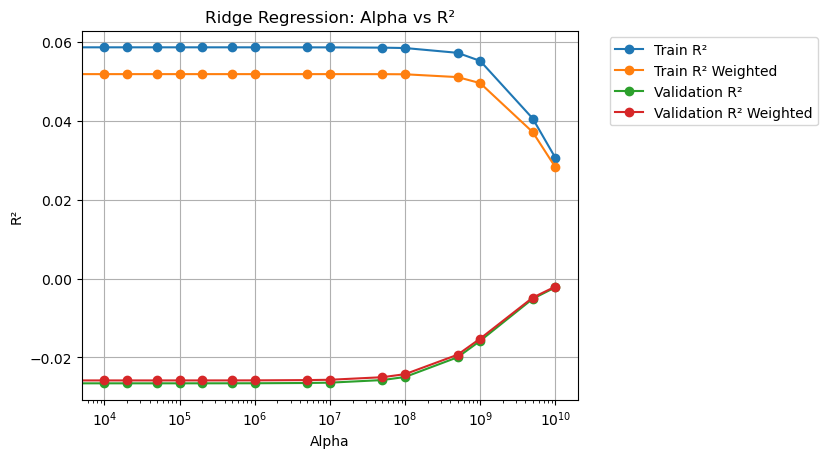

In [136]:
plt.plot(ridge_results_df['alpha'], ridge_results_df['train_r2'], marker='o', label='Train R²')
plt.plot(ridge_results_df['alpha'], ridge_results_df['train_r2_weighted'], marker='o', label='Train R² Weighted')
plt.plot(ridge_results_df['alpha'], ridge_results_df['val_r2'], marker='o', label='Validation R²')
plt.plot(ridge_results_df['alpha'], ridge_results_df['val_r2_weighted'], marker='o', label='Validation R² Weighted')
plt.xlabel('Alpha')
plt.ylabel('R²')
plt.title('Ridge Regression: Alpha vs R²')
plt.xscale('log')
plt.grid()
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

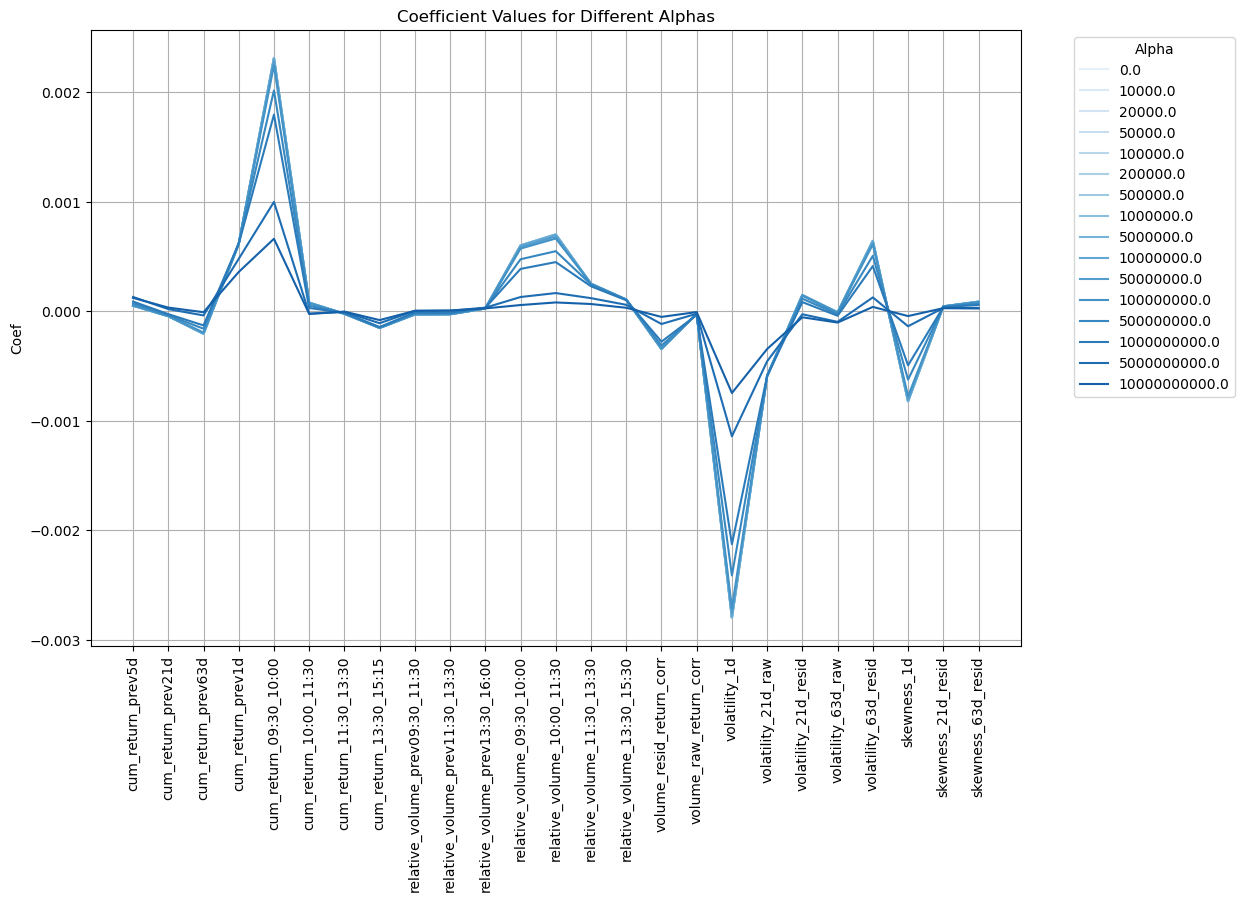

In [137]:
unique_alphas = ridge_results_df['alpha'].unique()
colors = [plt.cm.Blues((i+2)/21) for i in range(19)]

plt.figure(figsize=(12, 8))

for alpha, color in zip(unique_alphas, colors):
    subset = ridge_results_df[ridge_results_df['alpha'] == alpha]
    plt.plot(
        feature_cols, 
        subset[feature_cols].values.flatten(), 
        label=f'{alpha}', 
        color=color
    )

plt.ylabel('Coef')
plt.title('Coefficient Values for Different Alphas')
plt.xticks(rotation=90)
plt.legend(title='Alpha', loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid()
plt.show()

In [ ]:
# Train-test split 
train_df = features_df[features_df['Date'] < '2014-01-01']
test_df  = features_df[features_df['Date'] >= '2014-01-01']

# Select features and target

X_train = train_df[feature_cols].copy()
y_train = train_df[target_col].copy()
X_test  = test_df[feature_cols].copy()
y_test  = test_df[target_col].copy()


# Add a constant column (intercept) and fit OLS
X_train = sm.add_constant(X_train, has_constant='add')
X_test  = sm.add_constant(X_test, has_constant='add')

ols_model = sm.OLS(y_train, X_train).fit()
print('r_squared is', ols_model.rsquared)

r_squared is 0.06274076436101717


Train R^2 : 0.061366
Test  R^2 : -0.029112


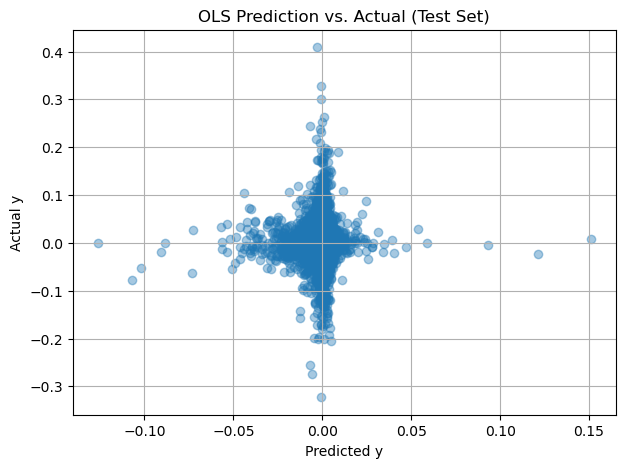

/var/folders/jt/6qgmwsm10s9_y2bmdw82zhxr0000gn/T/ipykernel_72772/1365083042.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['y_pred'] = y_pred_test


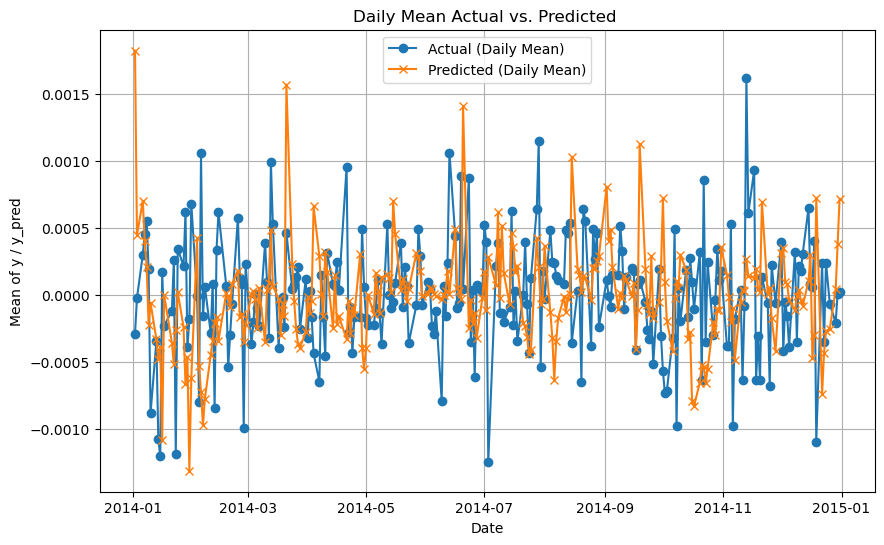

In [81]:

# Predict on train/test and compute R^2
y_pred_train = ols_model.predict(X_train)
y_pred_test  = ols_model.predict(X_test)

train_r2 = r2_score(y_train, y_pred_train)
test_r2  = r2_score(y_test, y_pred_test)

print(f"Train R^2 : {train_r2:.6f}")
print(f"Test  R^2 : {test_r2:.6f}")

# Plot: predicted vs. actual (test set)
plt.figure(figsize=(7,5))
plt.scatter(y_pred_test, y_test, alpha=0.4)
plt.xlabel("Predicted y")
plt.ylabel("Actual y")
plt.title("OLS Prediction vs. Actual (Test Set)")
plt.grid(True)
plt.show()

# Optionally, group the test predictions by Date and plot daily means
test_df['y_pred'] = y_pred_test
daily_avg = test_df.groupby('Date')[['y','y_pred']].mean()
plt.figure(figsize=(10,6))
plt.plot(daily_avg.index, daily_avg['y'], label="Actual (Daily Mean)", marker='o')
plt.plot(daily_avg.index, daily_avg['y_pred'], label="Predicted (Daily Mean)", marker='x')
plt.xlabel("Date")
plt.ylabel("Mean of y / y_pred")
plt.title("Daily Mean Actual vs. Predicted ")
plt.legend()
plt.grid(True)
plt.show()
